# ECON240 (Regression), Fall 2021, Problem Set 5
Satej Soman, satej@berkeley.edu

---

# 0 Preliminaries: install packages, etc.

In [139]:
! pip3 install numpy pandas matplotlib statsmodels scipy tqdm

In [153]:
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import binom as Binomial
from scipy.stats import multinomial as Multinomial
from scipy.stats import norm as Normal
from tqdm import trange

sns.set_theme(context = "notebook", palette = "bright")
plt.rc("axes.spines", top = False, right = False)
plt.rc("font", **{'family':'sans-serif', 'sans-serif':'Helvetica Neue'})
plt.rc('figure', dpi = 200)

# index strings
LATE    = "LATE"
WALD_IV = "WALD-IV"
MLE     = "MLE"
EM      = "EM"


---

# 1. Dataset simulation

## 1.1 Strata draws and encouragement

In [141]:
πA = πN = πC = 1/3.0 
N  = 1000 

np.random.seed(0)

A = Multinomial(1, [πA, πN, πC]).rvs(N)
X = Binomial(1, 0.5).rvs(N)

A, X

(array([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]]),
 array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1

## 1.2 Treatment

In [142]:
D = (A.T * [np.zeros(N), X, np.ones(N)]).sum(axis = 0)
D

array([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1.

*Observe that actual treatment is deterministic given a unit’s compliance-strata/type
and encouragement. Comment.* 

Unlike an observed dataset, we know *a priori* to which compliance stratum each individual belongs. Given this information, and the encouragement, the exact outcome must be known deterministically.

## 1.3 Potential outcomes

In [170]:

Y0_A100 = Normal(0, 1).rvs(N)
Y0_A010 = Normal(1, 1).rvs(N)
Y1_A010 = Normal(3, 1).rvs(N)
Y1_A001 = Normal(4, 1).rvs(N)
Y0      = np.where(A[:, 0], Y0_A100, Y0_A010)
Y1      = np.where(A[:, 1], Y1_A010, Y1_A001)
Y       = np.where(D      , Y1,      Y0)

## 1.4 summary, average outcome difference vs late

In [144]:
data = pd.DataFrame(data = {"X": X, "D": D, "Y": Y})
data.describe()

,X,D,Y
count,1000.000000,1000.000000,1000.000000
mean,0.513000,0.486000,1.942039
std,0.500081,0.500054,2.022168
min,0.000000,0.000000,-2.649591
25%,0.000000,0.000000,0.205145
50%,1.000000,0.000000,1.884340
75%,1.000000,1.000000,3.664078
max,1.000000,1.000000,6.915213


In [145]:
# average outcome difference 
ΔȲ       = (Y[D == 1].mean() - Y[D == 0].mean())
pop_LATE = (Y[X == 1].mean() - Y[X == 0].mean()) / (D[X == 1].mean() - D[X == 0].mean())

print(f"ΔȲ = {ΔȲ}, population LATE = {pop_LATE}")

ΔȲ = 3.419944609586895, population LATE = 2.303092914373557


The naive difference in means overestimates the true LATE.

--- 

# 2 Estimation

## 2.1 WALD-IV estimate

As is typical, we will implement the sample analog of the population LATE estimate by regressing Y on a constant and $D$, with $X$ as an instrument for $D$.

In [146]:
# first, define an OLS (or copy-paste from the last pset)
def OLS(Y, X, W = 1, add_constant = True, α = 0.05):
    α = min(α, 1 - α)
    N = len(Y)
    regressors = list(X.columns)
    if add_constant: 
        X, regressors = np.c_[np.ones(X.shape[0]), X], ['intercept'] + regressors
    Γ_inv = np.linalg.inv((W * X.T) @ X)
    β = Γ_inv @ (W * X.T).dot(Y) 
    u = Y - X.dot(β)
    Ω = X.T.dot(X) * u.dot(u) / N
    Λ = Γ_inv @ Ω @ Γ_inv.T
    σ = np.sqrt(np.diag(Λ))
    q = stats.norm.ppf(1 - α / 2)
    output = pd.DataFrame(data = {
        "coefficient"   : β, 
        "standard error": σ,
        f"[{α/2}"       : β - q * σ, 
        f"{1-α/2}]"     : β + q * σ, 
}, index = regressors)
    output.vcv = ''; output.vcv = Λ  # monkeypatch the var-cov matrix into the output while suppressing pandas UserError
    return output

# next, regress D on X: 
stage_1 = OLS(D, data[["X"]], W = 1, add_constant = True)
stage_1

,coefficient,standard error,[0.025,0.975]
intercept,0.293634,0.020996,0.252484,0.334785
X,0.374981,0.029313,0.317528,0.432435


In [147]:
# next, regress Y on first stage fitted values:
data["D_"] = stage_1.loc["intercept", "coefficient"] + X * stage_1.loc["X", "coefficient"]
stage_2 = OLS(Y, data[["D_"]], W = 1, add_constant = True)
β       = {WALD_IV: stage_2["coefficient"].loc["D_"]}
stage_2

,coefficient,standard error,[0.025,0.975]
intercept,0.822736,0.173530,0.482624,1.162848
D_,2.303093,0.333142,1.650147,2.956039


Since the [0.025, 0.975] range of the standard error distribution does not contain the origin, we can reject the null of 0 LATE at the 5% significance level.

## 2.2 MLE-LATE estimate (complete data log-likelihood)

As we have seen, encouraged compliers and non-encouraged compliers are comparable, so we can express the LATE in terms of the complete data log-likelihood parameters: $\beta^{\text{LATE}} = \widehat{\mu}_{C1} - \widehat{\mu}_{C0}$

In [148]:
C   = A[:, 1] == 1

W1  = X[C] * D[C]
μC1 = (W1 * Y[C]).sum() / W1.sum()

W0  = (1 - X[C]) * (1 - D[C])
μC0 = (W0 * Y[C]).sum() / W0.sum()

β[MLE] = μC1 - μC0
β[MLE]

2.1374515964061587

## 2.3 MLE-LATE estimate (expectation maximization)

In [152]:
converged, tolerance = False, 1e-6

# initial weights 
μC0  = μC1  = μN0  = μA1  = 0
σ2C0 = σ2C1 = σ2N0 = σ2A1 = 1
π1   = π2   = π3   =        1/3.0

ϕ = lambda y, m, s: Normal(m, s).pdf(y)

def weights(w, y, m):
    d = w.sum()
    return (w * y).sum() / d, (w * (y - m)**2).sum() / d 

i = 0
print("running EM algorithm")
while not converged:
    Ã1 =\
        (1-X)*(1-D) * π1 * ϕ(Y, μN0, σ2N0) / (π1 * ϕ(Y, μN0, σ2N0) + π2 * ϕ(Y, μC0, σ2C0)) + \
           X *(1-D)
    
    Ã2 =\
        (1-X)*(1-D) * π2 * ϕ(Y, μC0, σ2C0) / (π1 * ϕ(Y, μN0, σ2N0) + π2 * ϕ(Y, μC0, σ2C0)) + \
           X *   D  * π2 * ϕ(Y, μC1, σ2C1) / (π2 * ϕ(Y, μC1, σ2C1) + π3 * ϕ(Y, μA1, σ2A1))

    Ã3 =\
        (1-X)*  D   +\
           X *  D   * π2 * ϕ(Y, μA1, σ2A1) / (π2 * ϕ(Y, μC1, σ2C1) + π3 * ϕ(Y, μA1, σ2A1))
    
    π1, π2, π3 = Ã1.sum()/N, Ã2.sum()/N, Ã3.sum()/N

    # single assignment for atomic updates:
    μC0_prev = μC0
    μC0, σ2C0, μC1, σ2C1, μN0, σ2N0, μA1, σ2A1 = chain(
        weights(Ã2 * (1-D) * (1-X),           Y, μC0),
        weights(Ã2 * D*X,                     Y, μC1),
        weights(Ã1 * ((1-D)*(1-X) + (1-D)*X), Y, μN0),
        weights(Ã3 * (D*(1-X) + D*X),         Y, μA1)
    )

    error = abs(μC0 - μC0_prev)
    converged = error < tolerance
    i += 1
    print(f"parameter difference after {i} iterations: {error:.3f}")
β[EM] = μC1 - μC0


running EM algorithm
parameter difference after 1 iterations: 0.424
parameter difference after 2 iterations: 0.101
parameter difference after 3 iterations: 0.072
parameter difference after 4 iterations: 0.044
parameter difference after 5 iterations: 0.026
parameter difference after 6 iterations: 0.014
parameter difference after 7 iterations: 0.007
parameter difference after 8 iterations: 0.004
parameter difference after 9 iterations: 0.002
parameter difference after 10 iterations: 0.001
parameter difference after 11 iterations: 0.001
parameter difference after 12 iterations: 0.001
parameter difference after 13 iterations: 0.001
parameter difference after 14 iterations: 0.001
parameter difference after 15 iterations: 0.001
parameter difference after 16 iterations: 0.001
parameter difference after 17 iterations: 0.001
parameter difference after 18 iterations: 0.001
parameter difference after 19 iterations: 0.001
parameter difference after 20 iterations: 0.001
parameter difference after 2

## 2.4 comparison of point estimates

In [157]:
print(pd.DataFrame(data = β.values(), index = β.keys()).rename(columns = {0: "estimate"}))

         estimate
WALD_IV  2.303093
MLE      2.137452
EM       2.616640


--- 

# 3 Parametric Bootstrap

## 3.1 generate bootstrap datasets

In [167]:
B = 1000

β_bs = []

for b in range(B):
    A_b       = Multinomial(1, [π1, π2, π3]).rvs(N)
    D_b       = (A_b.T * [np.zeros(N), X, np.ones(N)]).sum(axis = 0)
    Y0_A100_b = Normal(0, 1).rvs(N)
    Y0_A010_b = Normal(1, 1).rvs(N)
    Y1_A010_b = Normal(3, 1).rvs(N)
    Y1_A001_b = Normal(4, 1).rvs(N)
    Y0_b      = np.where(A_b[:, 0], Y0_A100_b, Y0_A010_b)
    Y1_b      = np.where(A_b[:, 1], Y1_A010_b, Y1_A001_b)
    Y_b       = np.where(D_b      , Y1_b,      Y0_b)
    
    converged = False

    # initial weights 
    μC0_b  = μC1_b  = μN0_b  = μA1_b  = 0
    σ2C0_b = σ2C1_b = σ2N0_b = σ2A1_b = 1
    π1_b   = π2_b   = π3_b   =          1/3.0

    while not converged:
        Ã1_b =\
            (1-X)*(1-D_b) * π1_b * ϕ(Y_b, μN0_b, σ2N0_b) / (π1_b * ϕ(Y_b, μN0_b, σ2N0_b) + π2_b * ϕ(Y_b, μC0_b, σ2C0_b)) + \
            X    *(1-D_b)
        
        Ã2_b =\
            (1-X)*(1-D_b) * π2_b * ϕ(Y_b, μC0_b, σ2C0_b) / (π1_b * ϕ(Y_b, μN0_b, σ2N0_b) + π2_b * ϕ(Y_b, μC0_b, σ2C0_b)) + \
            X *   D_b     * π2_b * ϕ(Y_b, μC1_b, σ2C1_b) / (π2_b * ϕ(Y_b, μC1_b, σ2C1_b) + π3_b * ϕ(Y_b, μA1_b, σ2A1_b))

        Ã3_b =\
            (1-X) * D_b +\
            X     * D_b * π2_b * ϕ(Y_b, μA1_b, σ2A1_b) / (π2_b * ϕ(Y_b, μC1_b, σ2C1_b) + π3 * ϕ(Y_b, μA1_b, σ2A1_b))
        
        π1_b, π2_b, π3_b = Ã1_b.sum()/N, Ã2_b.sum()/N, Ã3_b.sum()/N

        # single assignment for atomic updates:
        μC0_prev_b = μC0_b
        μC0_b, σ2C0_b, μC1_b, σ2C1_b, μN0_b, σ2N0_b, μA1_b, σ2A1_b = chain(
            weights(Ã2_b * (1-D_b) * (1-X),             Y_b, μC0_b),
            weights(Ã2_b * D_b*X,                       Y_b, μC1_b),
            weights(Ã1_b * ((1-D_b)*(1-X) + (1-D_b)*X), Y_b, μN0_b),
            weights(Ã3_b * (D_b*(1-X) + D_b*X),         Y_b, μA1_b)
        )

        error = abs(μC0 - μC0_prev)
        converged = error < tolerance

    β_bs.append(μC1_b - μC0_b)

parameter difference after 42 iterations: 0.000: : 0it [54:39, ?it/s]
parameter difference after 42 iterations: 0.000: : 0it [53:58, ?it/s]
parameter difference after 42 iterations: 0.000: : 0it [53:28, ?it/s]


## 3.2 95% confidence interval

In [168]:
β_bs_sorted = sorted(β_bs)
CI = β_bs_sorted[int(0.025*B)], β_bs_sorted[int(0.975*B)]
CI

(2.8477875829484876, 3.173102569476022)

## 3.3 Histogram

(array([0.07655102, 0.26792858, 0.45930614, 1.03343882, 1.83722457,
        1.79894906, 2.67928583, 3.59789812, 4.05720426, 4.86099001,
        4.51651041, 3.67444914, 3.06204095, 2.5644593 , 1.79894906,
        1.18654087, 0.49758165, 0.11482654, 0.11482654, 0.07655102]),
 array([2.76105072, 2.78717708, 2.81330345, 2.83942982, 2.86555618,
        2.89168255, 2.91780891, 2.94393528, 2.97006164, 2.99618801,
        3.02231437, 3.04844074, 3.0745671 , 3.10069347, 3.12681983,
        3.1529462 , 3.17907256, 3.20519893, 3.23132529, 3.25745166,
        3.28357802]),
 <BarContainer object of 20 artists>)

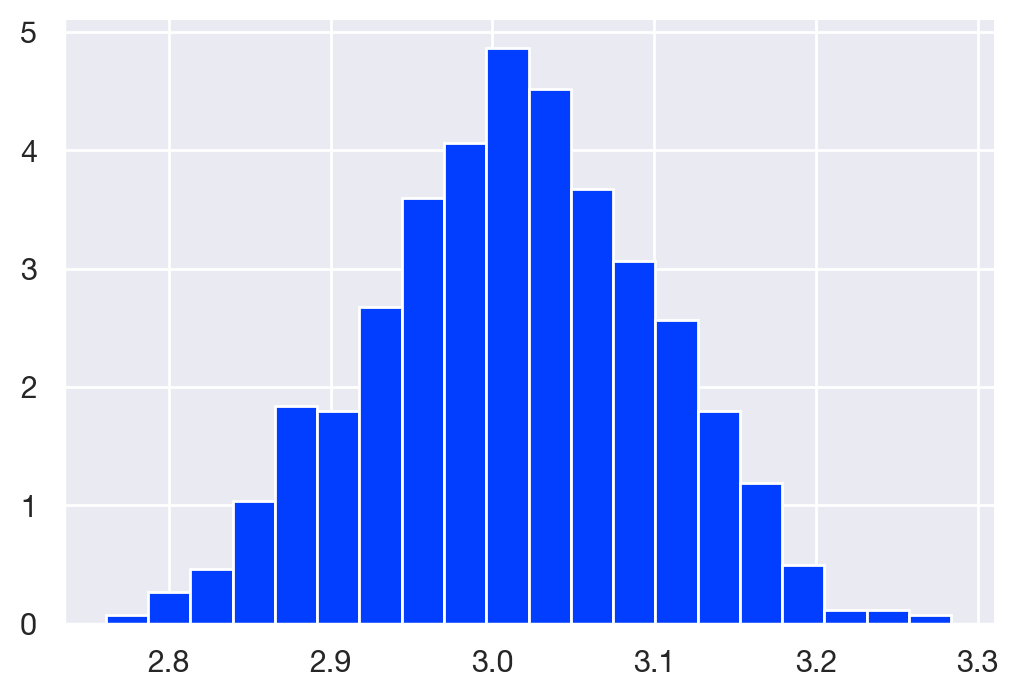

In [169]:
plt.hist(β_bs_sorted, bins = 20, density = True)

## 3.4 varying compliance stratum size 

Since we can only observe exogenous variation in the complier stratrum, reducing the size of that stratum will give us similar estimates, but increase our standard errors.